# Read Data

In [2]:
import json

In [3]:
# llamaparse ballanced
with open('fixed_res/GT/benchmark_data.md', encoding='utf8') as f:
    benchmark_md = f.read()

benchmark_data = []
for page in benchmark_md.split("\n\n---\n\n"):
    if page.strip():
        benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-AF24_Alexander_Redman_Final.pdf.md', encoding='utf8') as f:
    redman_benchmark_md = f.read()

redman_benchmark_data = []
for page in redman_benchmark_md.split("\n\n---\n\n"):
    if page.strip():
        redman_benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-attention_paper.pdf.md', encoding='utf8') as f:
    attention_benchmark_md = f.read()

attention_benchmark_data = []   
for page in attention_benchmark_md.split("\n---\n"):
    if page.strip():
        attention_benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-Astra_AR_2023 (15052024)_LR-1-220.pdf.md', encoding='utf8') as f:
    astra_ar_220_benchmark_md = f.read()

astra_ar_220_benchmark_data = []
for page in astra_ar_220_benchmark_md.split("\n---\n"):
    if page.strip():
        astra_ar_220_benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-AR for improved learnability.pdf.md', encoding='utf8') as f:
    ar_benchmark_md = f.read()

ar_benchmark_data = []
for page in ar_benchmark_md.split("\n---\n"):
    if page.strip():
        ar_benchmark_data.append({"markdown": page.strip()})

combined_benchmark_data = benchmark_data + redman_benchmark_data + attention_benchmark_data + astra_ar_220_benchmark_data + ar_benchmark_data
len(combined_benchmark_data)

314

# Load Requirements

In [4]:
# !pip install torchmetrics python-Levenshtein

In [ ]:
# Character Error rate (CER)
from torchmetrics.text import CharErrorRate
from torchmetrics.text import WordErrorRate
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text import BLEUScore
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
import Levenshtein
import tqdm

cer = CharErrorRate()
wer = WordErrorRate()
rouge = ROUGEScore()
bleu = BLEUScore()

d:\Universal-Doc-Parsing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def get_normalized_edit_distance(s1, s2):
    edit_distance = Levenshtein.distance(s1, s2)
    return edit_distance / max(len(s1), len(s2))

In [7]:
# Order Score
from difflib import SequenceMatcher
from scipy.stats import kendalltau, spearmanr
import re
import numpy as np

def split_into_blocks(text):
    # Basic split: by double newlines (paragraph/section boundaries)
    blocks = [block.strip() for block in text.strip().split('\n') if block.strip()]
    # remove empty blocks and blocks with only whitespace
    blocks = [block for block in blocks if block and not re.match(r'^\s*$', block)]
    return blocks

def get_block_order_indices(pred_blocks, target_blocks):
    indices = []
    indices_score = []
    for j, t_block in enumerate(target_blocks):
        sequence_score = []
        for i, p_block in enumerate(pred_blocks):
            score = SequenceMatcher(None, t_block, p_block).ratio()
            sequence_score.append(score)
        if sequence_score:
            max_index = sequence_score.index(max(sequence_score))
            indices.append(max_index)
            indices_score.append(max(sequence_score))
    return indices, indices_score

def order_score_predict(pred_text, target_text):
    pred_blocks = split_into_blocks(pred_text)
    target_blocks = split_into_blocks(target_text)

    target_indices = list(range(len(target_blocks)))
    pred_indices, _ = get_block_order_indices(pred_blocks, target_blocks)

    if sum(pred_indices) == 0:
        return 0.0, 0.0  # not enough data to compare order
    
    tau, _ = kendalltau(target_indices, pred_indices)
    # spearman = spearmanr(target_indices, pred_indices)[0]
    spearman = 99

    # if nan print the values
    if np.isnan(tau) or np.isnan(spearman):
        # print(f"target_indices: {target_indices}, \npred_indices: {pred_indices}")
        return 0.0, 0.0

    return max(tau, 0), max(spearman, 0)  # ensure non-negative

In [8]:
import numpy as np
import pandas as pd

# benchmarking function
def benchmark(benchmark_pages, parser_pages, type="markdown"):
    cer_scores = []
    wer_scores = []
    rouge_scores = []
    bleu_scores = []
    tau_scores = []
    spearman_scores = []
    meteor_scores = []
    ned_scores = []
    # for i, page in enumerate(benchmark_pages):
    for i in tqdm.tqdm(range(len(benchmark_pages))):
        target = benchmark_pages[i]['markdown']
        preds = parser_pages[i][type]

        # cer score
        # cer_score = cer(preds=preds, target=target).item()
        # cer_scores.append(round(cer_score, 4))

        # wer score
        wer_score = wer(preds=preds, target=target).item()
        wer_scores.append(round(wer_score, 4))

        # rouge score
        # rouge_score = rouge(preds=preds, target=target)
        # rougeL_recall = rouge_score["rougeL_recall"].item()
        # rouge_scores.append(round(rougeL_recall, 4))

        # bleu score
        bleu_score = bleu(preds=[preds], target=[[target]]).item()
        bleu_scores.append(round(bleu_score, 4))

        # order score
        tau_score, spearman_score = order_score_predict(preds, target)
        # handle NaN values
        # if tau_score == 0.0 and spearman_score == 0.0:
        #     print(f"{i} - tau: {tau_score}, spearman: {spearman_score}")

        tau_score = float(tau_score)
        # spearman_score = float(spearman_score)
        tau_scores.append(round(tau_score, 4))
        # spearman_scores.append(round(spearman_score, 4))

        # meteor score
        # tokenize the text into words
        # target_words = word_tokenize(target)
        # preds_words = word_tokenize(preds)
        # meteor_score = single_meteor_score(target_words, preds_words)
        # meteor_scores.append(round(meteor_score, 4))
    
        # normalized edit distance score
        # ned_score = Levenshtein.distance(target, preds) / max(len(target), len(preds))
        # ned_score = float(ned_score)
        # ned_scores.append(round(ned_score, 4))

        # Print scores
        # print(f"CER: {cer_score:.4f}")
        # print(f"WER: {wer_score:.4f}")
        # print(f"METEOR: {meteor_score:.4f}")
        # # print(f"ROUGE: {rougeL_recall:.4f}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print(f"Order Score (Kendall Tau): {tau_score:.4f}")
        # print(f"Order Score (Spearman): {spearman_score:.4f}")
        # print(f"Normalized Edit Distance: {ned_score:.4f}")
        # print()

    # calculate average scores
    # avg_cer = sum(cer_scores) / len(cer_scores)
    avg_wer = sum(wer_scores) / len(wer_scores)
    # avg_rouge = sum(rouge_scores) / len(rouge_scores)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_tau = sum(tau_scores) / len(tau_scores)
    # avg_spearman = sum(spearman_scores) / len(spearman_scores)
    # avg_meteor = sum(meteor_scores) / len(meteor_scores)
    # avg_ned = sum(ned_scores) / len(ned_scores)
    
    # print(f"CER List: {cer_scores}")
    # print(f"Average CER: {avg_cer:.4f}")
    print(f"WER List: {wer_scores}")
    print(f"Average WER: {avg_wer:.4f}")
    # print(f"Meteor List: {meteor_scores}")
    # print(f"Average Meteor: {avg_meteor:.4f}")
    # print(f"ROUGE List: {rouge_scores}")
    # print(f"Average ROUGE: {avg_rouge:.4f}")
    print(f"BLEU List: {bleu_scores}")
    print(f"Average BLEU: {avg_bleu:.4f}")
    print(f"Order Score (Kendall Tau) List: {tau_scores}")
    print(f"Average Order Score (Kendall Tau): {avg_tau:.4f}")
    # print(f"Order Score (Spearman) List: {spearman_scores}")
    # print(f"Average Order Score (Spearman): {avg_spearman:.4f}")
    # print(f"Normalized Edit Distance List: {ned_scores}")
    # print(f"Average Normalized Edit Distance: {avg_ned:.4f}")

    return {
        # "cer": cer_scores,
        "wer": wer_scores,
        # "meteor": meteor_scores,
        # "rouge": rouge_scores,
        "bleu": bleu_scores,
        "tau": tau_scores,
        # "spearman": spearman_scores,
        # "ned": ned_scores
    }

# Our Pipeline

In [9]:
# read json
with open('fixed_res/Ours/dummy-data.pdf.json', encoding='utf8') as f:
    dummy_res = json.load(f)

with open('fixed_res/Ours/AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_res = json.load(f)

with open('fixed_res/Ours/attention_paper.pdf.json', encoding="utf8") as f:
    attention_res = json.load(f)

with open('fixed_res/Ours/Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_res = json.load(f)

with open('fixed_res/Ours/AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_res = json.load(f)

combined_res = dummy_res["pages"].copy() + redman_res["pages"].copy() + attention_res["pages"].copy() + astra_ar_220_res["pages"].copy() + ar_res["pages"].copy()

# benchmarking llamaparse
print("Length data:", len(combined_res))
our_score = benchmark(combined_benchmark_data, combined_res)

Length data: 314


100%|██████████| 314/314 [02:39<00:00,  1.96it/s]

WER List: [0.1187, 0.5764, 0.1991, 0.4587, 0.1436, 0.8571, 0.0545, 0.4667, 0.1716, 1.554, 0.8731, 0.5542, 0.5726, 0.3191, 0.4161, 0.5139, 1.4157, 0.7484, 0.3827, 0.5202, 0.44, 0.4303, 0.453, 0.4539, 0.4872, 0.424, 0.5191, 0.6378, 0.59, 0.3812, 0.4041, 0.428, 0.5192, 0.4444, 0.5121, 8.7838, 0.5636, 0.4732, 0.2, 0.4529, 0.5373, 0.6096, 0.6323, 0.534, 0.6879, 0.4603, 0.4231, 0.2915, 0.2759, 0.4751, 0.5887, 0.9766, 0.5954, 0.5471, 0.9331, 0.6904, 0.3205, 0.6008, 0.5361, 0.5052, 0.5852, 0.5252, 0.6618, 0.5745, 0.5424, 0.6066, 0.3881, 1.0531, 0.1331, 0.1515, 0.0363, 0.0916, 0.2795, 0.3969, 0.1323, 0.1081, 0.113, 0.1154, 0.1532, 0.0633, 0.042, 0.0695, 24.1158, 1.7714, 3.4474, 0.2222, 0.0302, 0.0361, 0.8207, 0.4961, 0.6237, 0.8901, 0.9184, 0.129, 0.1834, 0.3948, 1.0408, 0.1242, 0.3091, 0.1445, 0.1269, 0.4086, 0.097, 0.5083, 0.4121, 0.1882, 0.3506, 0.1972, 0.1614, 0.161, 0.5714, 0.2955, 0.5345, 0.4347, 0.356, 0.351, 0.6623, 0.1216, 0.0661, 0.7133, 0.0566, 0.03, 0.3086, 0.5316, 0.4528, 0.3791, 0

In [10]:
# read json
with open('fixed_res/Ours/dummy-data.pdf.json', encoding='utf8') as f:
    dummy_res = json.load(f)

with open('fixed_res/Ours/AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_res = json.load(f)

with open('fixed_res/Ours/attention_paper.pdf.json', encoding="utf8") as f:
    attention_res = json.load(f)

with open('fixed_res/Ours/Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_res = json.load(f)

with open('fixed_res/Ours/AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_res = json.load(f)

combined_res = dummy_res["pages"].copy() + redman_res["pages"].copy() + attention_res["pages"].copy() + astra_ar_220_res["pages"].copy() + ar_res["pages"].copy()

# benchmarking llamaparse
print("Length data:", len(combined_res))
our_text_score = benchmark(combined_benchmark_data, combined_res, type="text")

Length data: 314


100%|██████████| 314/314 [02:32<00:00,  2.06it/s]

WER List: [0.21, 0.7556, 0.2064, 0.4037, 0.2774, 0.8254, 0.2, 0.2702, 0.3657, 1.5683, 0.8854, 0.5341, 0.5778, 0.3262, 0.4472, 0.5789, 1.4307, 0.7484, 0.3827, 0.5695, 0.4622, 0.541, 0.4701, 0.461, 0.5043, 0.432, 0.5953, 0.6417, 0.5956, 0.4062, 0.4449, 0.4317, 0.5192, 0.4501, 0.5121, 2.6486, 0.5773, 0.4821, 0.2348, 0.4978, 0.5137, 0.6175, 0.6254, 0.534, 0.6141, 0.5146, 0.5096, 0.3767, 0.3172, 0.7104, 0.6, 1.2103, 0.6031, 0.5561, 0.9247, 0.7614, 0.3429, 0.597, 0.6333, 0.5104, 0.5795, 0.5094, 0.6676, 0.6473, 0.5452, 0.6011, 0.6014, 1.0725, 0.3384, 0.0252, 0.155, 0.0723, 0.2904, 0.1614, 0.1362, 0.1098, 0.0728, 0.1951, 0.1772, 0.096, 0.1002, 0.0471, 6.1474, 1.7714, 3.0132, 1.037, 0.2613, 0.0241, 0.6853, 0.876, 0.6819, 0.8901, 0.9113, 1.0581, 0.1992, 0.3948, 1.1497, 0.1225, 0.2583, 0.2121, 0.2779, 0.3969, 0.1524, 0.2095, 0.4092, 0.2565, 0.8117, 0.2111, 0.172, 0.2966, 2.4286, 0.8409, 0.6552, 0.4513, 0.3833, 0.2843, 0.4774, 0.1537, 0.0643, 0.1467, 0.0629, 0.0487, 0.4568, 0.8987, 0.5472, 0.3651,

# LlamaParse

In [11]:
# read json
with open('fixed_res/Llama/llamaparse-dummy_scanned.pdf.json', encoding='utf8') as f:
    llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-attention_paper.pdf.json', encoding="utf8") as f:
    attention_llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_llamaparse_res = json.load(f)

combined_llamaparse_res = llamaparse_res["pages"].copy() + redman_llamaparse_res["pages"].copy() + attention_llamaparse_res["pages"].copy() + astra_ar_220_llamaparse_res["pages"].copy() + ar_llamaparse_res["pages"].copy()

# benchmarking llamaparse
print(len(combined_llamaparse_res))
llamaparse_score = benchmark(combined_benchmark_data, combined_llamaparse_res)

314


100%|██████████| 314/314 [02:08<00:00,  2.44it/s]

WER List: [0.1096, 0.8289, 0.2899, 0.867, 0.1294, 0.4286, 0.0545, 0.0105, 0.1242, 0.6043, 0.4149, 0.498, 0.438, 0.2837, 0.3354, 0.4675, 0.412, 0.5382, 0.7284, 0.6726, 0.6889, 0.2131, 0.4573, 0.4397, 0.5256, 0.564, 0.5836, 0.7205, 0.6205, 0.3031, 0.6816, 0.786, 0.5962, 0.8405, 0.6653, 0.2973, 0.4845, 0.625, 0.8522, 0.3677, 0.1725, 0.1474, 0.1581, 0.3241, 0.6946, 0.159, 0.2596, 0.6547, 0.1655, 0.5158, 0.7094, 0.7734, 0.1832, 0.7354, 0.6904, 0.2132, 0.2788, 0.7338, 0.6806, 0.6042, 0.7386, 0.2987, 0.8176, 0.6218, 0.7994, 0.6967, 0.1923, 0.6957, 0.057, 0.0, 0.1574, 0.0064, 0.9808, 0.0067, 0.0117, 0.0017, 0.0, 0.0439, 0.3278, 0.0019, 0.0023, 0.0022, 1.1684, 1.4857, 1.0789, 0.0, 0.0, 0.006, 0.6534, 0.5853, 0.0296, 0.0711, 0.2553, 0.5484, 0.0253, 0.3458, 0.4524, 0.0721, 0.1501, 0.0956, 0.0785, 0.1362, 0.06, 0.0415, 0.0749, 0.0659, 0.3983, 0.0858, 0.0899, 0.048, 13.2857, 0.2727, 0.7069, 0.0808, 0.251, 0.3686, 0.417, 0.4518, 0.6232, 0.5485, 0.1069, 0.0225, 0.4815, 0.443, 0.4906, 0.4163, 0.0446, 

In [12]:
# llamaparse ballanced
with open('fixed_res/Llama/llamaparse-balanced-dummy-data.pdf.md', encoding='utf8') as f:
    llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-AF24_Alexander_Redman_Final.pdf.md', encoding='utf8') as f:
    redman_llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-attention_paper.pdf.md', encoding='utf8') as f:
    attention_llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-Astra_AR_2023 (15052024)_LR-1-220.pdf.md', encoding='utf8') as f:
    astra_ar_220_llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-AR for improved learnability.pdf.md', encoding='utf8') as f:
    ar_llamaparse_b_res = f.read()

combined_llamaparse_b_text = llamaparse_b_res + "\n---\n" + redman_llamaparse_b_res + "\n---\n" + attention_llamaparse_b_res + "\n---\n" + astra_ar_220_llamaparse_b_res + "\n---\n" + ar_llamaparse_b_res
combined_llamaparse_b_res = []
for page in combined_llamaparse_b_text.split("\n---\n"):
    if page.strip():
        combined_llamaparse_b_res.append({"markdown": page.strip()})

# benchmarking llamaparse
print(len(combined_llamaparse_b_res))
llamaparse_b_score = benchmark(combined_benchmark_data, combined_llamaparse_b_res)

314


100%|██████████| 314/314 [01:43<00:00,  3.05it/s]

WER List: [0.3973, 0.7923, 0.8082, 0.5734, 1.0, 12.0, 0.1636, 0.4947, 0.8894, 0.7914, 0.709, 0.7309, 0.8047, 0.7766, 0.764, 0.7214, 0.7491, 0.5987, 0.6872, 0.583, 0.6667, 0.6762, 0.6709, 0.7589, 0.6838, 0.74, 0.7947, 0.6969, 0.7258, 0.6781, 0.6939, 0.69, 0.7885, 0.7977, 0.8266, 0.6649, 0.8282, 0.8125, 0.7652, 0.6816, 0.8157, 0.7012, 0.6804, 0.7469, 0.7584, 0.6318, 0.7436, 0.6726, 0.3379, 0.4434, 0.7057, 0.8598, 0.6489, 0.7399, 0.6234, 0.6142, 0.6987, 0.749, 0.7917, 0.6667, 0.7869, 0.7075, 0.7588, 0.7127, 0.774, 0.724, 0.4965, 0.6763, 0.8783, 0.0237, 0.1985, 0.008, 0.2219, 0.1726, 0.1051, 0.1338, 0.0345, 0.2813, 0.3911, 0.2399, 0.0723, 0.0538, 0.3789, 0.9571, 0.8816, 0.3333, 0.4925, 0.0301, 0.9163, 0.9264, 0.3854, 0.4246, 0.4184, 0.7355, 0.8188, 0.6686, 0.8061, 0.1846, 0.6093, 0.3566, 0.6707, 0.7821, 0.3349, 0.4502, 0.7061, 0.1812, 2.8636, 0.4826, 0.5, 0.1328, 6.0, 1.5, 0.7586, 0.4656, 0.535, 0.5353, 0.4943, 0.1399, 0.5661, 0.5327, 0.6143, 0.4831, 0.7284, 0.7595, 0.717, 0.5837, 0.06, 0.

# Mistral OCR

In [13]:
# read json
with open('fixed_res/Mistral/mistralocr-dummy-data.pdf.json', encoding='utf8') as f:
    mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-attention_paper.pdf.json', encoding="utf8") as f:
    attention_mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_mistralocr_res = json.load(f)

combined_mistralocr_res = mistralocr_res["pages"].copy() + redman_mistralocr_res["pages"].copy() + attention_mistralocr_res["pages"].copy() + astra_ar_220_mistralocr_res["pages"].copy() + ar_mistralocr_res["pages"].copy()

# benchmarking mistralocr
print(len(combined_mistralocr_res))
mistralocr_score = benchmark(combined_benchmark_data, combined_mistralocr_res)

314


100%|██████████| 314/314 [01:58<00:00,  2.64it/s]

WER List: [0.2329, 0.224, 0.6384, 0.5275, 0.1305, 0.5873, 0.0545, 0.6491, 0.3612, 0.777, 0.8483, 0.7871, 0.8865, 0.8511, 0.4752, 0.8607, 0.8277, 0.8376, 0.7613, 0.7175, 0.8444, 0.8115, 0.859, 0.844, 0.8248, 0.872, 0.8358, 0.7638, 0.8172, 0.4563, 0.8286, 0.8192, 0.8029, 0.8348, 0.8427, 0.8108, 0.8729, 0.9286, 0.8957, 0.8744, 0.8314, 0.8725, 0.8316, 0.8673, 0.8322, 0.8787, 0.8814, 0.7848, 0.7241, 0.7783, 0.6943, 0.9112, 0.874, 0.8879, 0.7908, 0.7716, 0.4199, 0.8175, 0.8583, 0.7604, 0.892, 0.8774, 0.8706, 0.84, 0.8729, 0.8415, 0.8671, 0.8599, 0.4259, 0.0849, 0.2663, 0.0354, 0.2493, 0.2422, 0.177, 0.1767, 0.1226, 0.1984, 0.0861, 0.0537, 0.028, 0.0202, 0.4105, 0.4143, 0.4342, 0.7778, 0.4271, 0.0361, 0.5299, 0.6705, 0.0821, 0.125, 0.2128, 0.8742, 0.2898, 0.7925, 0.5136, 0.1779, 0.362, 0.4149, 0.3142, 0.8444, 0.1016, 0.1079, 0.147, 0.1624, 0.1082, 0.1415, 0.0952, 0.1356, 0.8571, 0.2955, 0.8793, 0.0998, 0.3949, 0.2451, 0.4642, 0.094, 0.0482, 0.0903, 0.2474, 0.161, 0.6914, 1.0, 0.8679, 0.1256, 

# Deepseek Janus

In [14]:
# compare the two dictionaries["pages"]
combined_benchmark_data_2 = benchmark_data + redman_benchmark_data + attention_benchmark_data + ar_benchmark_data

len(combined_benchmark_data_2)

94

In [20]:
# read json
with open('fixed_res/Deepseek/janus_dummy-data.pdf.json', encoding="utf8") as f:
    janus_res = json.load(f)

with open('fixed_res/Deepseek/janus_AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_janus_res = json.load(f)

with open('fixed_res/Deepseek/janus_attention_paper.pdf.json', encoding="utf8") as f:
    attention_janus_res = json.load(f)

# with open('fixed_res/Deepseek janus/janus-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
#     astra_ar_220_janus_res = json.load(f)

with open('fixed_res/Deepseek/janus_AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_janus_res = json.load(f)

combined_janus_res = janus_res["pages"].copy() + redman_janus_res["pages"].copy() + attention_janus_res["pages"].copy() + ar_janus_res["pages"].copy()

# benchmarking janus
print(len(combined_janus_res))
janus_score = benchmark(combined_benchmark_data_2, combined_janus_res)


94


100%|██████████| 94/94 [01:42<00:00,  1.09s/it]

WER List: [0.7854, 0.9959, 0.8697, 0.7798, 0.9726, 38.4603, 0.1091, 4.7439, 2.228, 7.1403, 0.9288, 0.8434, 0.9499, 0.8794, 3.823, 0.8514, 0.7903, 0.8439, 8.893, 0.7758, 5.2444, 0.8689, 8.2222, 0.883, 0.8162, 0.796, 0.8944, 1.248, 0.8726, 0.6812, 0.8898, 0.8672, 0.7981, 0.7493, 0.8387, 0.7622, 0.8557, 0.9048, 0.9087, 0.7534, 0.8118, 0.8526, 0.9381, 6.8704, 4.9497, 9.2008, 0.859, 0.7803, 15.3517, 5.3575, 7.6, 0.8808, 0.8702, 5.1076, 8.8243, 0.7563, 3.1506, 0.8403, 0.9194, 7.2188, 6.2898, 0.8553, 0.9353, 6.3418, 0.8898, 0.8962, 0.6608, 0.8019, 0.5437, 0.963, 5.8232, 1.0659, 0.8411, 4.6031, 7.0759, 0.8422, 0.91, 3.0293, 2.3722, 0.8061, 2.8392, 2.0157, 31.5158, 20.4286, 0.7895, 1.615, 0.954, 1.5126, 1.751, 2.2958, 1.8701, 1.3132, 0.935, 2.9088]
Average WER: 3.2654
BLEU List: [0.0869, 0.0, 0.0053, 0.2227, 0.0, 0.0043, 0.7783, 0.0404, 0.0167, 0.0149, 0.0195, 0.0138, 0.029, 0.0726, 0.0382, 0.0271, 0.0386, 0.018, 0.0244, 0.0528, 0.0211, 0.0164, 0.021, 0.0338, 0.0715, 0.0494, 0.0598, 0.0708, 0.0

In [22]:
# read json
with open('fixed_res/Deepseek/deepseekvl2-dummy-data.pdf.json', encoding="utf8") as f:
    vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-attention_paper.pdf.json', encoding="utf8") as f:
    attention_vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_vl2_res = json.load(f)

combined_vl2_res = vl2_res["pages"].copy() + redman_vl2_res["pages"].copy() + attention_vl2_res["pages"].copy() + astra_ar_220_vl2_res["pages"].copy() + ar_vl2_res["pages"].copy()

# benchmarking vl2
print(len(combined_vl2_res))
vl2_score = benchmark(combined_benchmark_data, combined_vl2_res)

314


100%|██████████| 314/314 [03:21<00:00,  1.55it/s]

WER List: [3.6484, 0.389, 0.6266, 0.7752, 0.1765, 0.5079, 0.2364, 0.3123, 0.14, 0.4281, 0.8452, 0.8072, 0.4301, 0.8617, 0.5683, 0.5728, 0.7715, 0.8758, 0.7325, 1.0897, 0.3822, 0.8689, 0.7692, 0.7908, 0.7265, 1.044, 0.8182, 0.7953, 0.7978, 0.6562, 0.3878, 0.8192, 0.7933, 0.5954, 0.3508, 0.8757, 0.8419, 0.9792, 0.8217, 0.4305, 0.9608, 0.8048, 0.2887, 0.5123, 0.8087, 1.2343, 0.7853, 0.2601, 0.6897, 0.4434, 0.7585, 0.3972, 6.8053, 0.8117, 0.7531, 0.335, 0.4199, 0.7985, 0.8417, 0.7188, 0.7869, 0.4874, 0.8412, 0.7782, 0.822, 0.7842, 0.7972, 0.7585, 0.1293, 0.9595, 0.9758, 0.0675, 0.2795, 0.343, 0.9319, 0.1595, 0.5268, 0.1984, 0.7987, 0.0461, 0.8462, 0.2735, 0.4316, 0.3429, 0.4079, 1.2222, 0.5729, 0.0361, 0.6414, 5.845, 2.0319, 0.653, 0.234, 0.6548, 0.9368, 0.8674, 2.1224, 0.693, 0.5077, 0.9883, 0.5529, 0.7743, 0.739, 0.2573, 2.9597, 0.7812, 0.6883, 6.7935, 0.6349, 0.5508, 2.1429, 0.2955, 1.0172, 0.0879, 0.4047, 0.8412, 0.4283, 0.117, 0.1036, 0.3883, 0.4486, 0.2846, 0.6543, 25.5443, 1.3585, 0

# Qwen 2.5 VL

In [23]:
# read json
with open('fixed_res/Qwen/qwen_dummy-data.pdf.json', encoding="utf8") as f:
    qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_attention_paper.pdf.json', encoding="utf8") as f:
    attention_qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_qwen_res = json.load(f)

combined_qwen_res = qwen_res["pages"].copy() + redman_qwen_res["pages"].copy() + attention_qwen_res["pages"].copy() + astra_ar_220_qwen_res["pages"].copy() + ar_qwen_res["pages"].copy()

# benchmarking qwen
print(len(combined_qwen_res))
qwen_score = benchmark(combined_benchmark_data, combined_qwen_res)

314


100%|██████████| 314/314 [03:38<00:00,  1.44it/s]

WER List: [0.242, 0.6477, 0.164, 0.3945, 0.1162, 0.5556, 0.2182, 0.3228, 0.0903, 0.5791, 0.613, 0.7229, 0.3588, 0.8014, 0.4907, 0.4954, 0.779, 0.8121, 0.3374, 0.6771, 0.4489, 0.791, 0.7692, 0.4823, 0.735, 0.74, 0.5396, 0.7598, 0.5069, 0.3812, 0.7592, 0.7897, 0.7356, 0.8063, 0.7581, 0.6486, 0.8179, 0.6429, 0.7739, 0.3946, 0.5412, 0.741, 0.2474, 7.0802, 0.3255, 0.5607, 0.5256, 0.2287, 0.4276, 0.6923, 0.7057, 0.8341, 0.5916, 0.7534, 0.7029, 0.7411, 0.3526, 0.7452, 0.8389, 0.6927, 0.8182, 0.805, 0.8324, 0.7673, 0.8023, 0.7814, 0.5524, 0.7005, 0.1103, 0.6446, 0.1017, 0.0804, 0.3014, 0.296, 0.1654, 0.1269, 0.067, 0.1252, 0.0747, 0.0537, 0.1166, 0.0717, 0.8, 0.6857, 0.7237, 0.2593, 0.4975, 0.0361, 0.7371, 0.6744, 0.4789, 0.2198, 0.0745, 0.6839, 0.0969, 7.513, 0.4354, 0.6158, 0.3664, 0.5175, 0.2266, 0.4825, 0.3326, 0.4419, 0.1931, 0.1318, 0.1558, 0.4849, 0.2354, 0.1469, 1.0, 0.8182, 0.8103, 0.1021, 0.358, 0.2392, 0.666, 0.5206, 0.0571, 0.3205, 0.413, 0.1985, 0.8395, 0.5443, 0.7736, 0.0977, 0.0

# Visualize

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker

# Create a DataFrame from the scores
scores = {
    "Metrics": ["WER", "BLEU", "Order Score (Kendall Tau)"],
    "Vidavox Doc": [np.mean(our_score["wer"]), np.mean(our_score["bleu"]), np.mean(our_score["tau"])],
    "Vidavox Doc (Text Only)": [np.mean(our_text_score["wer"]), np.mean(our_text_score["bleu"]), np.mean(our_text_score["tau"])],
    "LlamaParse Premium": [np.mean(llamaparse_score["wer"]), np.mean(llamaparse_score["bleu"]), np.mean(llamaparse_score["tau"])],
    "LlamaParse Balanced": [np.mean(llamaparse_b_score["wer"]), np.mean(llamaparse_b_score["bleu"]), np.mean(llamaparse_b_score["tau"])],
    "MistralOCR": [np.mean(mistralocr_score["wer"]), np.mean(mistralocr_score["bleu"]), np.mean(mistralocr_score["tau"])],
    "deepseek-ai/Janus-Pro-7B": [np.mean(janus_score["wer"]), np.mean(janus_score["bleu"]), np.mean(janus_score["tau"])],
    "deepseek-ai/deepseek-vl2-tiny": [np.mean(vl2_score["wer"]), np.mean(vl2_score["bleu"]), np.mean(vl2_score["tau"])],
    "Qwen/Qwen2.5-VL-7B-Instruct": [np.mean(qwen_score["wer"]), np.mean(qwen_score["bleu"]), np.mean(qwen_score["tau"])],
}

# Create DataFrame
df = pd.DataFrame(scores)

# Set 'Metrics' as index and transpose for plotting
df = df.set_index('Metrics')
df_transposed = df.T # Models as rows, Metrics as columns
df_transposed

Metrics,WER,BLEU,Order Score (Kendall Tau)
Vidavox Doc,0.543549,0.625802,0.652721
Vidavox Doc (Text Only),0.493288,0.628549,0.643439
LlamaParse Premium,0.390090,0.678203,0.593509
LlamaParse Balanced,0.664196,0.417284,0.609416
MistralOCR,0.418129,0.549928,0.373489
deepseek-ai/Janus-Pro-7B,3.265423,0.047267,0.203999
deepseek-ai/deepseek-vl2-tiny,1.194567,0.398262,0.484797
Qwen/Qwen2.5-VL-7B-Instruct,0.464290,0.560201,0.471052


In [25]:
# save the dataframe to csv
df_transposed.to_csv('fixed_res/GT/benchmark_scores.csv')

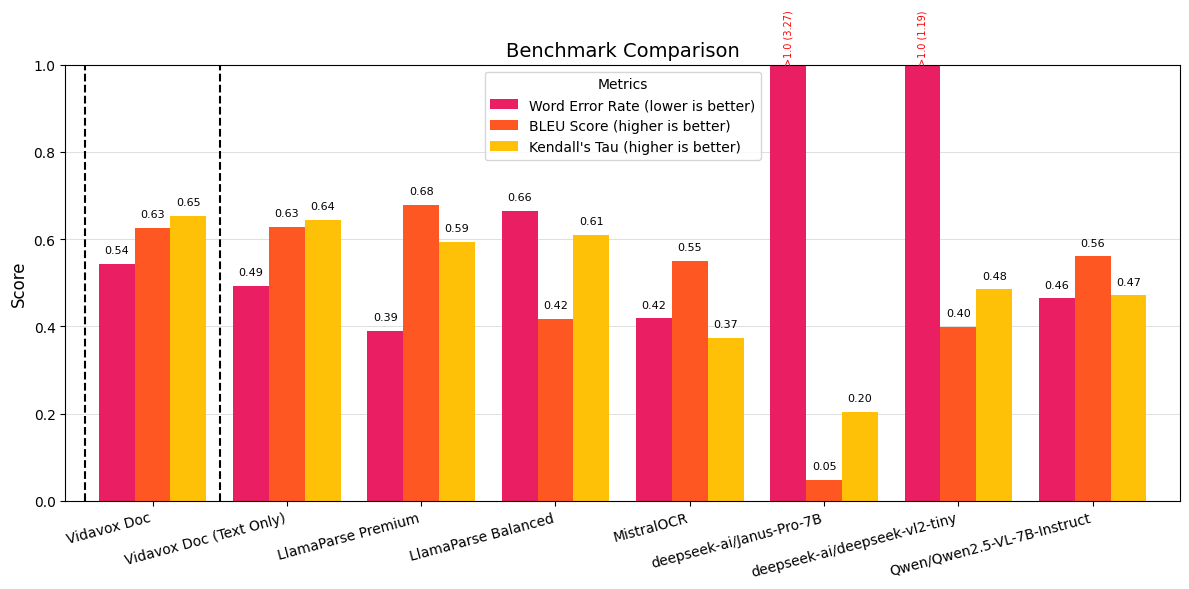

In [26]:
# Filter for models shown in the image
# NOTE: Make sure the index names in df_transposed exactly match these strings
models_to_plot = ['Vidavox Doc', 'Vidavox Doc (Text Only)', 'LlamaParse Premium', 'LlamaParse Balanced', 'MistralOCR', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/deepseek-vl2-tiny', 'Qwen/Qwen2.5-VL-7B-Instruct']
# Ensure only models present in the dataframe index are selected
models_available = [model for model in models_to_plot if model in df_transposed.index]
df_plot = df_transposed.loc[models_available]


# Rename columns for the legend (matching the image)
# Note: Ensure these column names exist in df_plot before renaming
df_plot = df_plot.rename(columns={
    'WER': 'Word Error Rate (lower is better)',
    'BLEU': 'BLEU Score (higher is better)',
    'Order Score (Kendall Tau)': "Kendall's Tau (higher is better)"
})

# Plotting
fig, ax = plt.subplots(figsize=(12, 6)) # Increased width slightly for more models

# Define colors - ensure enough colors for the number of metrics (columns)
# Using 3 colors for the 3 metrics
colors = ['#E91E63', '#FF5722', '#FFC107'] # Yellow/Orange, Orange/Red, Pink/Red

# --- Create the bar plot ---
# Use only the first n_metrics colors if more are provided
df_plot.plot(kind='bar', ax=ax, width=0.8, color=colors[:len(df_plot.columns)])

# --- Calculations for annotations and lines ---
n_models = len(df_plot.index)
n_metrics = len(df_plot.columns)
x = np.arange(n_models)  # the label locations (0, 1, 2...)
group_width = 0.8 # Corresponds to 'width' in df_plot.plot
bar_width = group_width / n_metrics

# --- Add Bar Value Labels ---
for i, model in enumerate(df_plot.index):
    for j, metric in enumerate(df_plot.columns):
        value = df_plot.loc[model, metric]
        # Calculate precise x-position for each bar's label
        bar_x_pos = x[i] - group_width / 2 + (j + 0.5) * bar_width
        # Only add label if the value is within the plotted range (0 to 1)
        if 0 <= value <= 1.0:
             ax.text(bar_x_pos, value + 0.02, f'{value:.2f}', # Format to 2 decimal places
                     ha='center', va='bottom', fontsize=8, color='black') # Reduced fontsize slightly
        # Optional: Add a marker or different label for clipped bars
        elif value > 1.0:
             ax.text(bar_x_pos, 1.0, f'>1.0 ({value:.2f})', # Indicate clipping and show actual value
                     ha='center', va='bottom', fontsize=7, color='red', rotation=90)


# --- Customize Appearance ---
# Title and Labels
# Updated title to reflect the models plotted
ax.set_title('Benchmark Comparison', fontsize=14) # More generic title
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('') # Remove x-axis label

# X-axis Ticks
ax.set_xticks(x)
# Rotate labels if they overlap
ax.set_xticklabels(df_plot.index, rotation=15, ha='right', fontsize=10)

# Y-axis Ticks and Limits
# *** THIS IS THE CORRECTED LINE ***
ax.set_ylim(0, 1.0) # Set y-axis limits from 0 to exactly 1.0
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.2)) # Ticks every 0.2
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f')) # Format y-ticks to 1 decimal place

# Gridlines (horizontal)
ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
ax.set_axisbelow(True) # Keep grid behind bars

# Legend
# ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), fontsize=9) # Move legend outside

# Dashed Vertical Lines (Update to cover all gaps)
line_start_pos = x[0] - group_width / 2 - (1-group_width)/2 # Position before first group starts
ax.axvline(line_start_pos, color='black', linestyle='--', linewidth=1.5, ymin=0.0, ymax=1.0)

# Calculate positions halfway between the centers of all adjacent groups
line_pos = (x[0] + x[0+1]) / 2
ax.axvline(line_pos, color='black', linestyle='--', linewidth=1.5, ymin=0.0, ymax=1.0)

# Adjust layout and display
plt.tight_layout() # Adjust rect to make space for external legend
plt.show()